In [1]:
import os
import torch
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
from transformers import (
    set_seed,
    Trainer,
    AutoConfig,
    AutoModelWithLMHead,
    TextDataset,
    PreTrainedTokenizer,
    AutoTokenizer,
    HfArgumentParser,
    DataCollatorForLanguageModeling)

from language_modeling import (
    get_dataset,
    ModelArguments,
    DataTrainingArguments,
    TrainingArguments)

parser = HfArgumentParser(
    (ModelArguments,
     DataTrainingArguments,
     TrainingArguments))

INFO:PyTorch version 1.5.0 available.


In [2]:
# model_args, data_args, training_args = parser.parse_args_into_dataclasses("""
#     --output_dir=output \
#     --model_type=bert \
#     --model_name_or_path=bert-base-cased \
#     --do_train \
#     --train_data_file=/export/home/Data/EnglishWikipedia/bmccann_txt/en.valid \
#     --do_eval \
#     --eval_data_file=/export/home/Data/EnglishWikipedia/bmccann_txt/en.valid \
#     --mlm""".split())
model_args, data_args, training_args = parser.parse_args_into_dataclasses("""
    --output_dir=output-gpt2-tiny-interactive \
    --model_type=gpt2 \
    --model_name_or_path=/export/home/Experiments/20200624-sanity-check-wikitext2/output-gpt2-tiny/ \
    --config_name=/export/home/Experiments/configs/gpt2-tiny/ \
    --tokenizer_name=/export/home/Experiments/configs/gpt2-tiny/ \
    --do_train \
    --train_data_file=/export/home/Data/WikiText-2/wikitext-2-raw/wiki.train.raw \
    --do_eval \
    --eval_data_file=/export/home/Data/WikiText-2/wikitext-2-raw/wiki.valid.raw \
    --per_device_train_batch_size 128 \
    --per_device_eval_batch_size 128 \
    --weight_decay 0.01 \
    --learning_rate 5e-4 \
    --num_train_epochs 30 \
    --save_total_limit 1""".split())

training_args.per_device_train_batch_size = 128
training_args.per_device_eval_batch_size = 128

In [3]:
    if data_args.eval_data_file is None and training_args.do_eval:
        raise ValueError(
            "Cannot do evaluation without an evaluation data file. Either supply a file to --eval_data_file "
            "or remove the --do_eval argument."
        )

    if (
        os.path.exists(training_args.output_dir)
        and os.listdir(training_args.output_dir)
        and training_args.do_train
        and not training_args.overwrite_output_dir
    ):
        raise ValueError(
            f"Output directory ({training_args.output_dir}) already exists and is not empty. Use --overwrite_output_dir to overcome."
        )

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        training_args.local_rank,
        training_args.device,
        training_args.n_gpu,
        bool(training_args.local_rank != -1),
        training_args.fp16,
    )
    logger.info("Training/evaluation parameters %s", training_args)

    # Set seed
    set_seed(training_args.seed)

    # Load pretrained model and tokenizer
    #
    # Distributed training:
    # The .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.

    if model_args.config_name:
        config = AutoConfig.from_pretrained(model_args.config_name, cache_dir=model_args.cache_dir)
    elif model_args.model_name_or_path:
        config = AutoConfig.from_pretrained(model_args.model_name_or_path, cache_dir=model_args.cache_dir)
    else:
        config = CONFIG_MAPPING[model_args.model_type]()
        logger.warning("You are instantiating a new config instance from scratch.")

    if model_args.tokenizer_name:
        tokenizer = AutoTokenizer.from_pretrained(model_args.tokenizer_name, cache_dir=model_args.cache_dir)
    elif model_args.model_name_or_path:
        tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path, cache_dir=model_args.cache_dir)
    else:
        raise ValueError(
            "You are instantiating a new tokenizer from scratch. This is not supported, but you can do it from another script, save it,"
            "and load it from here, using --tokenizer_name"
        )

    if model_args.model_name_or_path:
        model = AutoModelWithLMHead.from_pretrained(
            model_args.model_name_or_path,
            from_tf=bool(".ckpt" in model_args.model_name_or_path),
            config=config,
            cache_dir=model_args.cache_dir,
        )
    else:
        logger.info("Training new model from scratch")
        model = AutoModelWithLMHead.from_config(config)

    model.resize_token_embeddings(len(tokenizer))

    if config.model_type in ["bert", "roberta", "distilbert", "camembert"] and not data_args.mlm:
        raise ValueError(
            "BERT and RoBERTa-like models do not have LM heads but masked LM heads. They must be run using the --mlm "
            "flag (masked language modeling)."
        )

    if data_args.block_size <= 0:
        data_args.block_size = tokenizer.max_len
        # Our input block size will be the max possible for the model
    else:
        data_args.block_size = min(data_args.block_size, tokenizer.max_len)

    # Get datasets

    train_dataset = get_dataset(data_args, tokenizer=tokenizer) if training_args.do_train else None
    eval_dataset = get_dataset(data_args, tokenizer=tokenizer, evaluate=True) if training_args.do_eval else None
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=data_args.mlm, mlm_probability=data_args.mlm_probability
    )

    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        prediction_loss_only=True,
    )

INFO:PyTorch: setting up devices
INFO:Training/evaluation parameters TrainingArguments(output_dir='output-gpt2-tiny-interactive', overwrite_output_dir=False, do_train=True, do_eval=True, do_predict=False, evaluate_during_training=False, per_device_train_batch_size=128, per_device_eval_batch_size=128, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, learning_rate=0.0005, weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=30.0, max_steps=-1, warmup_steps=0, logging_dir=None, logging_first_step=False, logging_steps=500, save_steps=500, save_total_limit=1, no_cuda=False, seed=42, fp16=False, fp16_opt_level='O1', local_rank=-1, tpu_num_cores=None, tpu_metrics_debug=False)
INFO:loading configuration file /export/home/Experiments/configs/gpt2-tiny/config.json
INFO:Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_

In [4]:
from influence_utils.influence import *
count_parameters(model) / (1024**2)

0.7705078125

In [5]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler


def custom_get_dataset(file_path: str,
                args: DataTrainingArguments,
                tokenizer: PreTrainedTokenizer):
    if args.line_by_line:
        return LineByLineTextDataset(
            tokenizer=tokenizer,
            file_path=file_path,
            block_size=args.block_size)
    else:
        return TextDataset(
            tokenizer=tokenizer,
            file_path=file_path,
            block_size=args.block_size,
            overwrite_cache=args.overwrite_cache)


def custom_get_train_dataloader(self) -> DataLoader:
    if self.train_dataset is None:
        raise ValueError("Trainer: training requires a train_dataset.")
    if False and is_tpu_available():
        train_sampler = get_tpu_sampler(self.train_dataset)
    else:
        train_sampler = (
            RandomSampler(self.train_dataset)
            if self.args.local_rank == -1
            else DistributedSampler(self.train_dataset)
        )

    batch_data_loader = DataLoader(
        self.train_dataset,
        batch_size=self.args.train_batch_size,
        sampler=train_sampler,
        collate_fn=self.data_collator.collate_batch,
    )
    
    instance_data_loader = DataLoader(
        self.train_dataset,
        batch_size=1,
        sampler=train_sampler,
        collate_fn=self.data_collator.collate_batch,
    )
    
    return batch_data_loader, instance_data_loader


def map_to_cpu_list_(inputs_collections):
    for d in inputs_collections:
        map_to_cpu_(d)


def map_to_cpu_(d):
    for k, v in d.items():
        d[k] = v.cpu()


In [6]:
# influences_collections = []
# test_input_collections = []
# all_train_inputs_collections = []
# for i in range(0, 25):
#     custom_eval_dataset = custom_get_dataset(
#         file_path=f"/export/home/Data/WikiText-2/articles/article-{i}.txt",
#         args=data_args,
#         tokenizer=tokenizer)

#     batch_train_loader, instance_train_loader = custom_get_train_dataloader(trainer)
#     eval_loader = trainer.get_eval_dataloader(eval_dataset=custom_eval_dataset)

#     print(batch_train_loader.batch_size,
#           instance_train_loader.batch_size,
#           eval_loader.batch_size)

#     for index, test_inputs in enumerate(eval_loader):
#         break
    
#     break
    
#     influences, train_inputs_collections = compute_influences(
#         n_gpu=training_args.n_gpu,
#         device=training_args.device,
#         model=model,
#         test_inputs=test_inputs,
#         batch_train_data_loader=batch_train_loader,
#         instance_train_data_loader=instance_train_loader)
    
#     map_to_cpu_list_(train_inputs_collections)
#     map_to_cpu_(test_inputs)
#     influences_collections.append(influences)
#     test_input_collections.append(test_inputs)
#     all_train_inputs_collections.append(train_inputs_collections)
#     if i % 2 == 0:
#         torch.save(test_input_collections, "/export/home/Experiments/20200615/pod0-test_input_collections.pkl")
#         torch.save(influences_collections, "/export/home/Experiments/20200615/pod0-influences_collections.pkl")
#         torch.save(all_train_inputs_collections, "/export/home/Experiments/20200615/pod0-all_train_inputs_collections.pkl")

In [7]:
eval_loaders = []

for i in range(600):
    custom_eval_dataset = custom_get_dataset(
        file_path=f"/export/home/Data/WikiText-2/articles/article-{i}.txt",
        args=data_args,
        tokenizer=tokenizer)

    eval_loader = trainer.get_eval_dataloader(eval_dataset=custom_eval_dataset)
#     if len(eval_loader) != 1:
#         raise ValueError
    eval_loaders.append(eval_loader)

INFO:Lock 139721663742544 acquired on /export/home/Data/WikiText-2/articles/cached_lm_GPT2Tokenizer_32_article-0.txt.lock
INFO:Loading features from cached file /export/home/Data/WikiText-2/articles/cached_lm_GPT2Tokenizer_32_article-0.txt [took 0.001 s]
INFO:Lock 139721663742544 released on /export/home/Data/WikiText-2/articles/cached_lm_GPT2Tokenizer_32_article-0.txt.lock
INFO:Lock 139721663742352 acquired on /export/home/Data/WikiText-2/articles/cached_lm_GPT2Tokenizer_32_article-1.txt.lock
INFO:Loading features from cached file /export/home/Data/WikiText-2/articles/cached_lm_GPT2Tokenizer_32_article-1.txt [took 0.000 s]
INFO:Lock 139721663742352 released on /export/home/Data/WikiText-2/articles/cached_lm_GPT2Tokenizer_32_article-1.txt.lock
INFO:Lock 139721663743248 acquired on /export/home/Data/WikiText-2/articles/cached_lm_GPT2Tokenizer_32_article-2.txt.lock
INFO:Loading features from cached file /export/home/Data/WikiText-2/articles/cached_lm_GPT2Tokenizer_32_article-2.txt [took 

In [8]:
# import torch
# from tqdm import trange
# from copy import deepcopy

# model.eval()
# losses_collections = []
# s_tests_collections = []
# grad_zs_collections = []
# for i in trange(len(eval_loaders)):
#     eval_loaders_copy = deepcopy(eval_loaders)
#     eval_loader_copy = eval_loaders_copy.pop(i)
# #     if len(eval_loader_copy) != 1:
# #         raise ValueError
#     losses = []
#     s_tests = []
#     for test_inputs in eval_loader_copy:
#         loss = get_loss(
#             n_gpu=training_args.n_gpu,
#             device=training_args.device,
#             model=model,
#             inputs=test_inputs)

#         s_test = compute_s_test(
#             n_gpu=training_args.n_gpu,
#             device=training_args.device,
#             model=model,
#             test_inputs=test_inputs,
#             train_data_loaders=eval_loaders_copy,
#             scale=200,
#             verbose=True)

#         with torch.no_grad():
#             loss = loss.cpu()
#             s_test = [X.cpu() for X in s_test]
#             losses.append(loss)
#             s_tests.append(s_test)

#     grad_zs = compute_grad_zs(
#         n_gpu=training_args.n_gpu,
#         device=training_args.device,
#         model=model,
#         data_loader=eval_loader_copy)

#     with torch.no_grad():
#         losses_collections.append(losses)
#         s_tests_collections.append(s_tests)
#         grad_zs_collections.append(grad_zs)
    
#     if i % 10 == 0:
#         torch.save({
#             "loss": losses_collections,
#             "s_test": s_tests_collections,
#             "grad_zs": grad_zs_collections},
#             f"/export/home/Experiments/20200616/output_collections.{i}.pkl")

#         # Release memory
#         losses_collections = []
#         s_tests_collections = []
#         grad_zs_collections = []


In [9]:
gradients_sum = None
total_num_examples = 0
for eval_loader in tqdm(eval_loaders):
    for inputs in eval_loader:
        gradients = compute_gradients(
            model=model,
            n_gpu=training_args.n_gpu,
            device=training_args.device,
            inputs=inputs,
            params_filter=[
                "bert.pooler.dense.weight",
                "bert.pooler.dense.bias"],
            weight_decay=training_args.weight_decay,
            weight_decay_ignores = [
                "bias", "LayerNorm.weight"])

        num_examples = inputs["labels"].shape[0]
        total_num_examples += num_examples
        with torch.no_grad():
            if gradients_sum is None:
                gradients_sum = torch.cat([x.view(-1) for x in gradients]) * num_examples
            else:
                gradients_sum += torch.cat([x.view(-1) for x in gradients]) * num_examples


100%|██████████| 600/600 [00:19<00:00, 31.25it/s]


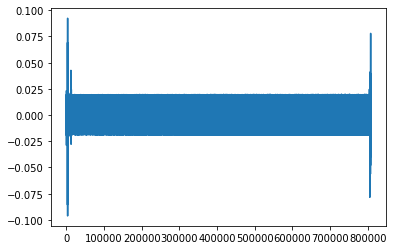

In [10]:
import matplotlib.pyplot as plt
plt.plot(gradients_sum.cpu().detach()/total_num_examples)

In [11]:
(gradients_sum/total_num_examples).norm()

tensor(5.1874, device='cuda:0')

In [ ]:
import torch
from tqdm import trange
from copy import deepcopy

model.eval()
s_trains_collections = []
batch_size_collections = []
for i in range(len(eval_loaders)):
    eval_loader_copy = deepcopy(eval_loaders[i])
#     if len(eval_loader_copy) != 1:
#         raise ValueError
    s_trains = []
    batch_sizes = []
    for inputs in eval_loader_copy:
        s_train = compute_s_test(
            n_gpu=training_args.n_gpu,
            device=training_args.device,
            model=model,
            test_inputs=inputs,
            train_data_loaders=eval_loaders,
            scale=200,
            verbose=True,
            params_filter=[
                "bert.pooler.dense.weight",
                "bert.pooler.dense.bias"],
            weight_decay=training_args.weight_decay,
            weight_decay_ignores = [
                "bias", "LayerNorm.weight"])

        with torch.no_grad():
            s_train = [X.cpu() for X in s_train]
            s_trains.append(s_train)
            batch_sizes.append(inputs["labels"].shape[0])

    with torch.no_grad():
        s_trains_collections.append(s_trains)
        batch_size_collections.append(batch_sizes)

    if i % 10 == 0:
        print(f"{i} / {len(eval_loaders)}")
        torch.save(
            {"s_train": s_trains_collections,
             "batch_size": batch_size_collections},
            f"/export/home/Experiments/20200626/output_collections.{i}.pkl")

        # Release memory
        s_trains_collections = []
        batch_size_collections = []


512.27 | 0.00: : 901it [01:01, 14.69it/s] 
519.25 | -0.02: : 901it [01:01, 14.66it/s]


0 / 600


512.06 | 0.00: : 901it [01:01, 14.68it/s] 
520.70 | -0.03: : 901it [01:01, 14.67it/s]
515.07 | -0.00: : 901it [01:01, 14.69it/s]
517.03 | 0.00: : 901it [01:01, 14.64it/s] 
513.21 | 0.00: : 901it [01:01, 14.62it/s] 
512.73 | 0.00: : 901it [01:01, 14.69it/s] 
518.26 | -0.00: : 901it [01:01, 14.64it/s]
512.49 | 0.00: : 901it [01:01, 14.69it/s] 
515.37 | -0.00: : 901it [01:01, 14.67it/s]
517.48 | 0.00: : 901it [01:01, 14.71it/s] 
511.61 | 0.00: : 901it [01:01, 14.67it/s] 
512.17 | 0.00: : 901it [01:01, 14.66it/s] 


10 / 600


513.12 | 0.00: : 901it [01:01, 14.64it/s] 
514.12 | -0.00: : 901it [01:01, 14.67it/s]
511.91 | 0.00: : 901it [01:01, 14.70it/s] 
511.87 | 0.00: : 901it [01:01, 14.60it/s] 
512.25 | -0.00: : 901it [01:01, 14.74it/s]
513.20 | -0.00: : 901it [01:01, 14.70it/s]
512.63 | -0.00: : 901it [01:01, 14.70it/s]
512.95 | -0.00: : 901it [01:01, 14.72it/s]
512.66 | -0.00: : 901it [01:01, 14.64it/s]
513.11 | 0.00: : 901it [01:01, 14.69it/s] 
512.31 | -0.00: : 901it [01:01, 14.60it/s]
513.02 | 0.00: : 901it [01:01, 14.69it/s] 
514.71 | -0.00: : 901it [01:00, 14.79it/s]
512.72 | 0.00: : 901it [01:01, 14.66it/s] 


20 / 600


512.51 | 0.00: : 901it [01:01, 14.71it/s] 
512.39 | 0.00: : 901it [01:01, 14.73it/s] 
511.60 | -0.00: : 901it [01:01, 14.69it/s]
517.54 | -0.00: : 901it [01:01, 14.73it/s]
512.23 | -0.00: : 901it [01:01, 14.68it/s]
512.65 | 0.00: : 901it [01:00, 14.78it/s] 
515.73 | 0.00: : 901it [01:01, 14.72it/s] 
511.90 | 0.00: : 901it [01:01, 14.75it/s] 
512.31 | -0.00: : 901it [01:01, 14.72it/s]
512.61 | 0.00: : 901it [01:01, 14.69it/s] 
513.26 | -0.00: : 901it [01:01, 14.68it/s]
512.50 | 0.00: : 901it [01:01, 14.67it/s] 
512.76 | -0.00: : 901it [01:01, 14.66it/s]
512.83 | -0.00: : 901it [01:01, 14.72it/s]
513.51 | -0.00: : 901it [01:01, 14.65it/s]


30 / 600


512.08 | 0.00: : 901it [01:01, 14.69it/s] 
512.15 | 0.00: : 901it [01:01, 14.69it/s] 
512.76 | -0.00: : 901it [01:01, 14.68it/s]
511.95 | 0.00: : 901it [01:01, 14.69it/s] 
511.98 | 0.00: : 901it [01:01, 14.64it/s] 
512.65 | 0.00: : 901it [01:01, 14.69it/s] 
513.59 | 0.00: : 901it [01:01, 14.68it/s] 
512.30 | -0.00: : 901it [01:00, 14.77it/s]
512.85 | -0.00: : 901it [01:01, 14.66it/s]
511.85 | 0.00: : 901it [01:01, 14.75it/s] 
511.54 | -0.00: : 901it [01:01, 14.69it/s]
532.23 | -0.01: : 901it [01:01, 14.70it/s]
513.02 | 0.00: : 901it [01:01, 14.69it/s] 
513.41 | -0.00: : 901it [01:01, 14.66it/s]
514.55 | -0.00: : 901it [01:01, 14.71it/s]
511.91 | 0.00: : 901it [01:01, 14.66it/s] 
513.07 | 0.00: : 901it [01:01, 14.68it/s] 
512.42 | 0.00: : 901it [01:01, 14.70it/s] 


40 / 600


512.05 | 0.00: : 901it [01:01, 14.68it/s] 
512.00 | 0.00: : 901it [01:01, 14.70it/s] 
514.48 | -0.00: : 901it [01:01, 14.63it/s]
512.35 | 0.00: : 901it [01:01, 14.66it/s] 
514.76 | 0.00: : 901it [01:01, 14.75it/s] 
514.74 | 0.00: : 901it [01:01, 14.70it/s] 
512.11 | -0.00: : 901it [01:01, 14.68it/s]
513.75 | 0.00: : 901it [01:01, 14.68it/s] 
512.79 | -0.00: : 901it [01:01, 14.73it/s]
512.57 | 0.00: : 901it [01:01, 14.73it/s] 
513.37 | 0.00: : 901it [01:01, 14.74it/s] 
780.81 | -1.25: : 901it [01:01, 14.66it/s]
514.66 | 0.00: : 901it [01:01, 14.73it/s] 
514.04 | 0.00: : 901it [01:01, 14.68it/s] 
511.67 | 0.00: : 901it [01:01, 14.73it/s] 
511.51 | -0.00: : 901it [01:01, 14.67it/s]
511.70 | 0.00: : 901it [01:01, 14.68it/s] 
512.57 | -0.00: : 901it [01:01, 14.67it/s]


50 / 600


513.64 | 0.00: : 901it [01:01, 14.64it/s] 
512.50 | 0.00: : 901it [01:01, 14.71it/s] 
517.59 | -0.00: : 901it [01:01, 14.62it/s]
513.52 | -0.00: : 901it [01:00, 14.77it/s]
513.81 | -0.00: : 901it [01:01, 14.67it/s]
512.92 | 0.00: : 901it [01:01, 14.70it/s] 
519.12 | -0.01: : 901it [01:01, 14.60it/s]
512.22 | 0.00: : 901it [01:01, 14.75it/s] 
522.35 | -0.04: : 901it [01:01, 14.64it/s]
512.21 | 0.00: : 901it [01:01, 14.67it/s] 
518.26 | -0.01: : 901it [01:01, 14.69it/s]
514.32 | 0.00: : 901it [01:01, 14.68it/s] 
512.65 | 0.00: : 837it [00:56, 13.58it/s] 

In [14]:
[(p[0], p[1].shape) for p in model.named_parameters()]

[('transformer.wte.weight', torch.Size([50257, 16])),
 ('transformer.wpe.weight', torch.Size([32, 16])),
 ('transformer.h.0.ln_1.weight', torch.Size([16])),
 ('transformer.h.0.ln_1.bias', torch.Size([16])),
 ('transformer.h.0.attn.c_attn.weight', torch.Size([16, 48])),
 ('transformer.h.0.attn.c_attn.bias', torch.Size([48])),
 ('transformer.h.0.attn.c_proj.weight', torch.Size([16, 16])),
 ('transformer.h.0.attn.c_proj.bias', torch.Size([16])),
 ('transformer.h.0.ln_2.weight', torch.Size([16])),
 ('transformer.h.0.ln_2.bias', torch.Size([16])),
 ('transformer.h.0.mlp.c_fc.weight', torch.Size([16, 64])),
 ('transformer.h.0.mlp.c_fc.bias', torch.Size([64])),
 ('transformer.h.0.mlp.c_proj.weight', torch.Size([64, 16])),
 ('transformer.h.0.mlp.c_proj.bias', torch.Size([16])),
 ('transformer.ln_f.weight', torch.Size([16])),
 ('transformer.ln_f.bias', torch.Size([16]))]

In [101]:
n_gpu=training_args.n_gpu
device=training_args.device
model=model
test_inputs=test_inputs
train_data_loaders=eval_loaders_copy

v = compute_gradients(model=model,
                      n_gpu=n_gpu,
                      device=device,
                      inputs=test_inputs)

# Technically, it's hv^-1
last_estimate = list(v).copy()
cumulative_num_samples = 0
for data_loader in train_data_loaders:
    for i, inputs in enumerate(data_loader):
        break
        this_estimate = compute_hessian_vector_products(
            model=model,
            n_gpu=n_gpu,
            device=device,
            vectors=last_estimate,
            inputs=inputs,
            params_filter=params_filter)
    break

In [102]:
for _ in range(10):
    this_estimate = compute_hessian_vector_products(
        model=model,
        n_gpu=n_gpu,
        device=device,
        vectors=last_estimate,
        inputs=inputs)
    # with torch.no_grad():
    #     this_estimate = [X.cpu() for X in this_estimate]
    new_estimate = [
        (a + b - c)
        for a, b, c in zip(v, [X.detach() for X in last_estimate], [X.detach() for X in this_estimate])]
    last_estimate = [X.detach() for X in new_estimate]

RuntimeError: CUDA out of memory. Tried to allocate 762.00 MiB (GPU 0; 15.75 GiB total capacity; 13.64 GiB already allocated; 400.38 MiB free; 14.39 GiB reserved in total by PyTorch) (malloc at /opt/conda/conda-bld/pytorch_1587428398394/work/c10/cuda/CUDACachingAllocator.cpp:289)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x4e (0x7f44608a3b5e in /opt/conda/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1f39d (0x7f446066539d in /opt/conda/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x2058e (0x7f446066658e in /opt/conda/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x291 (0x7f441dd02461 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0xddcb6b (0x7f441bfb2b6b in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xe26457 (0x7f441bffc457 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xdd3999 (0x7f4442f5e999 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #7: <unknown function> + 0xdd3cd7 (0x7f4442f5ecd7 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xb9aa3e (0x7f4442d25a3e in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::TensorIterator::allocate_outputs() + 0x38c (0x7f4442d25f5c in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::TensorIterator::build() + 0x208 (0x7f4442d27338 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: at::TensorIterator::binary_op(at::Tensor&, at::Tensor const&, at::Tensor const&, bool) + 0x146 (0x7f4442d27826 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::native::mul(at::Tensor const&, at::Tensor const&) + 0x3a (0x7f4442a474ca in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #13: <unknown function> + 0xdd93f8 (0x7f441bfaf3f8 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #14: <unknown function> + 0xe224d0 (0x7f4442fad4d0 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x2a8cd89 (0x7f4444c17d89 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #16: <unknown function> + 0xe224d0 (0x7f4442fad4d0 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #17: at::Tensor::mul(at::Tensor const&) const + 0xf0 (0x7f4461432140 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #18: torch::autograd::generated::LogSoftmaxBackwardDataBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x47d (0x7f44447d9f8d in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2ae8215 (0x7f4444c73215 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7f4444c70513 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7f4444c712f2 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::Engine::thread_init(int) + 0x39 (0x7f4444c69969 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #23: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7f44611dc558 in /opt/conda/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #24: <unknown function> + 0xc819d (0x7f447baf519d in /opt/conda/bin/../lib/libstdc++.so.6)
frame #25: <unknown function> + 0x76db (0x7f447f09e6db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #26: clone + 0x3f (0x7f447edc788f in /lib/x86_64-linux-gnu/libc.so.6)
